In [1]:
import sys
sys.dont_write_bytecode=True

import os

import torch

from modules import VoxelDataset
from modules import Encoder
from modules import Decoder
from modules import plot_objt_by_dataset, plot_objt_by_models, plot_part_by_voxel_coords, dataloader_collate_fn, get_voxel_map

from torch.utils.data import DataLoader
from torch.backends import cudnn

cudnn.benchmark = True

device = 'cuda'

In [2]:
pram = {
    'data_dir_pth': './dataset/chair_voxel_data_remove_duplicate',
    'part_counts_npy_pth': './dataset/each_chair_parts_count_remove_duplicate.npy',
    'outlier_objt_indices_npy_pth': './dataset/outlier_objt_indices.npy',
    'batch_size': 1,
    'voxel_map_shape': (128, 128, 128),
    'designate_num_objts': 10,
    'train_test_split_ratio_train': 1,
    'latent_dim': (64, 64),
    'decoder_lr': 3e-5,
    'encoder_lr': 3e-5,
}

In [3]:
train_dataset = VoxelDataset(pram['data_dir_pth'],
                             pram['part_counts_npy_pth'],
                             pram['outlier_objt_indices_npy_pth'],
                             designate_num_objts=pram['designate_num_objts'],
                             train_test_split_ratio_train=pram['train_test_split_ratio_train'],
                             is_train=True)

train_dataloader = DataLoader(train_dataset,
                              batch_size=pram['batch_size'],
                              shuffle=False,
                              collate_fn=dataloader_collate_fn,
                              pin_memory=True)

Trying to load 10 objects with total 159 parts into memory.


100%|██████████| 159/159 [00:00<00:00, 5748.74it/s]


In [4]:
test_dataset = VoxelDataset(pram['data_dir_pth'],
                            pram['part_counts_npy_pth'],
                            pram['outlier_objt_indices_npy_pth'],
                            designate_num_objts=pram['designate_num_objts'],
                            train_test_split_ratio_train=pram['train_test_split_ratio_train'],
                            is_train=False)

test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             collate_fn=dataloader_collate_fn,
                             pin_memory=True)

Trying to load 0 objects with total 0 parts into memory.


0it [00:00, ?it/s]


In [5]:
encoder = Encoder(pram['latent_dim'], ve_ch=8).to(device)

decoder = Decoder(pram['latent_dim'], vd_ch=8).to(device)

In [6]:
saved_ckpt = torch.load('./models/encoder_decoder_saved.pt')

In [7]:
encoder.load_state_dict(saved_ckpt['encoder_state_dict'])

decoder.load_state_dict(saved_ckpt['decoder_state_dict'])

<All keys matched successfully>

In [8]:
encoder.eval()

decoder.eval()

pass

In [9]:
voxel = get_voxel_map(train_dataset[0], device)
voxel = voxel.view(1, 1, *voxel.shape)

In [10]:
pred = torch.sigmoid(decoder(encoder(voxel)))

torch.max(pred)

tensor(0.6586, device='cuda:0', grad_fn=<MaxBackward1>)

In [11]:
(pred > 0.5).nonzero().shape

torch.Size([1765, 5])

In [ ]:
plot_objt_by_dataset(train_dataset, 0)

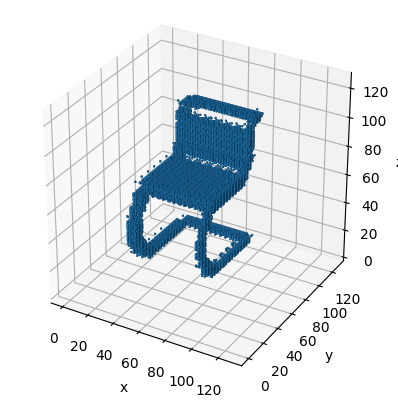

In [14]:
plot_objt_by_models(encoder, decoder, train_dataset, 2, 0.5, device)